In [2]:
style = 'mapbox://styles/ni1o1/cl39hgul1000514llp3yj7yh3'
style[16:]

'mapbox://styles/'

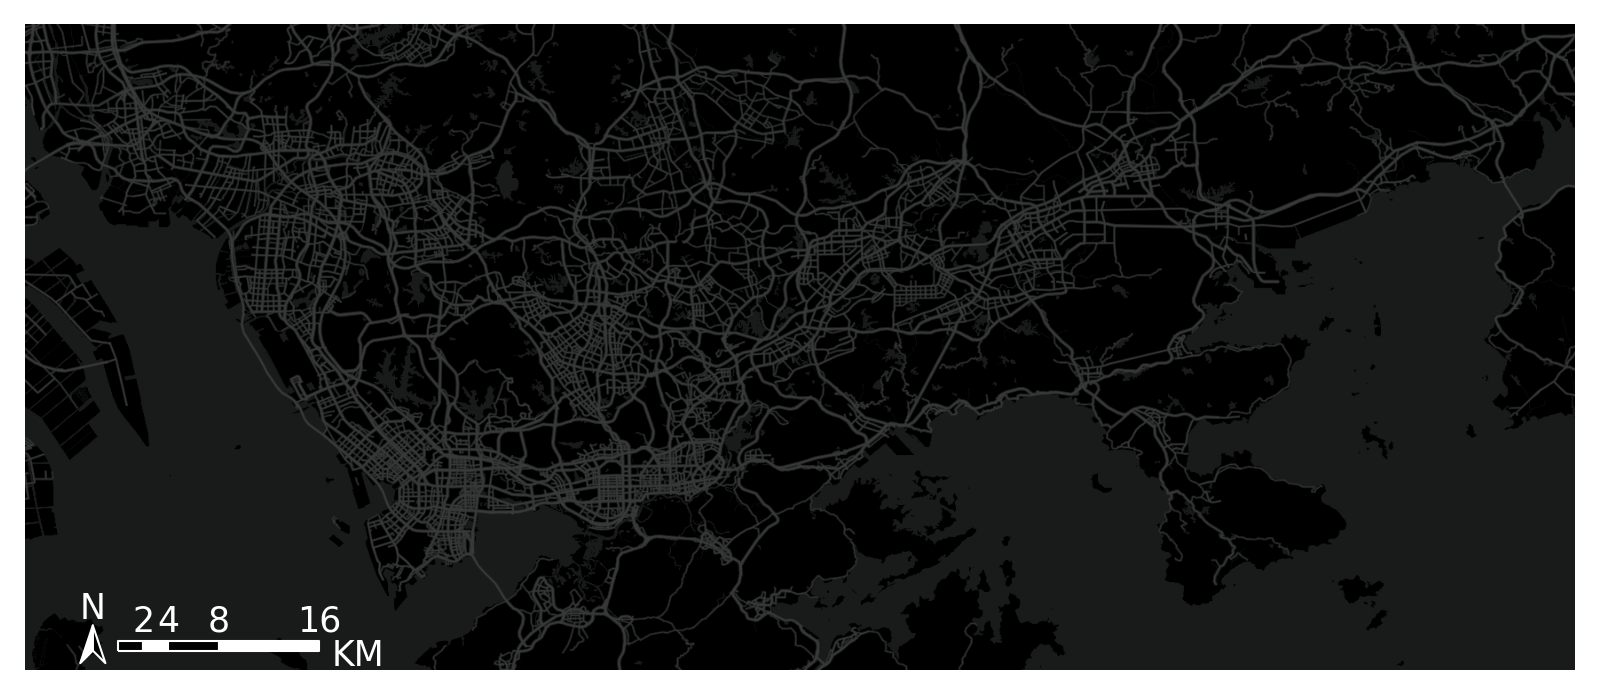

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
# Define display range
bounds = [113.6,22.4,114.8,22.9]

# Plot Frame
import matplotlib.pyplot as plt
fig =plt.figure(1,(8,8),dpi=250)
ax =plt.subplot(111)
plt.sca(ax)

# Add map basemap
tbd.plot_map(plt,bounds,zoom = 11,style = 12)

# Add scale bar and north arrow
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor='w',accuracy = 2000, rect = [0.06,0.03], zorder = 10)
plt.axis('off')
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
plt.show()